In [ ]:
pip install feature_engine

In [1]:
import numpy as np
import pandas as pd
import sklearn
import feature_engine
import seaborn as sns
from pandas import Series,DataFrame
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 标准化
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, ShuffleSplit, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import OneHotEncoder # 分类变量数值化

## 数据导入与预处理

In [2]:
train = pd.read_csv('/kaggle/input/regression/asap-bnu-train-2.csv')
print(train.shape)
test = pd.read_csv('/kaggle/input/regression/asap-bnu-test-2-features.csv')
print(test.shape)

(1440, 30)
(360, 29)


In [3]:
train.head()

,essay_id,score,genre,sent_num,max_depth,mean_depth,num_word,num_unique_word,num_noun,num_unique_noun,...,num_unique_lemma,mean_word_length,mean_sent_length,all_error_num,all_error_length,bigram_lemma_ttr,trigram_lemma_ttr,task_fulfillment,depth_variation_level,error_density
0,ZhzyDOa,4,argumentative,19,12,6.526316,524.0,200.0,93.0,38.0,...,172.0,3.347328,24.210526,12,71,0.830266,0.956967,partially,large,medium
1,CLQVOvt,2,argumentative,15,9,4.733333,263.0,120.0,38.0,22.0,...,111.0,3.030418,14.400000,13,57,0.847458,0.927660,partially,large,medium
2,PxtpUbL,4,argumentative,32,7,4.375000,552.0,177.0,78.0,35.0,...,157.0,3.025362,15.000000,6,42,0.799574,0.961538,mostly,small,low
3,3RMI4w8,4,argumentative,35,7,3.828571,510.0,219.0,94.0,52.0,...,193.0,3.088235,12.057143,37,208,0.900000,0.993166,partially,small,medium
4,n4HrmHw,4,argumentative,25,9,4.520000,378.0,155.0,68.0,39.0,...,139.0,3.084656,12.320000,15,86,0.888218,0.972727,partially,small,medium


In [4]:
# 区分分类和连续变量
continuous_cols = train.columns[3:27]
categorical_cols = train.columns[27:].append(train.columns[2:3])
print(continuous_cols)
print(categorical_cols)

Index(['sent_num', 'max_depth', 'mean_depth', 'num_word', 'num_unique_word',
       'num_noun', 'num_unique_noun', 'num_verb', 'num_unique_verb', 'num_adj',
       'num_unique_adj', 'num_adv', 'num_unique_adv', 'num_pron',
       'num_unique_pron', 'num_special_token', 'num_unique_special_token',
       'num_unique_lemma', 'mean_word_length', 'mean_sent_length',
       'all_error_num', 'all_error_length', 'bigram_lemma_ttr',
       'trigram_lemma_ttr'],
      dtype='object')
Index(['task_fulfillment', 'depth_variation_level', 'error_density', 'genre'], dtype='object')


处理分类变量
* onehot
* labelencoder

In [ ]:
onehot = OneHotEncoder()
encoded_train = onehot.fit_transform(train[categorical_cols])
encoded_test = onehot.fit_transform(test[categorical_cols])
encoded_test = encoded_test[encoded_train.columns]
encoded_train.head()

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_train = pd.DataFrame([])
label_test = pd.DataFrame([])

for feature in categorical_cols:
    le.fit(train[feature])
    label_train[feature] = le.transform(train[feature])
    label_test[feature] = le.transform(test[feature])
    
label_train.head()

,task_fulfillment,depth_variation_level,error_density,genre
0,3,0,2,0
1,3,0,2,0
2,2,1,1,0
3,3,1,2,0
4,3,1,2,0


In [6]:
scaler = StandardScaler()
scale_train = scaler.fit_transform(pd.DataFrame(train[continuous_cols]))
scale_test = scaler.fit_transform(pd.DataFrame(test[continuous_cols]))
scale_train_df = pd.DataFrame(scale_train, columns=continuous_cols)
scale_test_df = pd.DataFrame(scale_test, columns=continuous_cols)
scale_train_df.head()

,sent_num,max_depth,mean_depth,num_word,num_unique_word,num_noun,num_unique_noun,num_verb,num_unique_verb,num_adj,...,num_unique_pron,num_special_token,num_unique_special_token,num_unique_lemma,mean_word_length,mean_sent_length,all_error_num,all_error_length,bigram_lemma_ttr,trigram_lemma_ttr
0,-0.213126,1.169035,1.313761,0.557313,0.646494,0.615786,-0.187656,0.986546,1.120433,0.586017,...,0.699847,-0.062430,-0.446894,0.518636,2.343859,0.441760,-0.624081,-0.699253,-0.184588,0.138333
1,-0.639526,-0.218772,-0.544723,-0.943066,-0.870239,-1.071765,-1.097122,-0.650652,-0.942329,-0.990679,...,0.480955,-0.265823,0.207763,-0.797507,-1.294005,-0.506592,-0.542309,-0.880870,0.093771,-0.639539
2,1.172673,-1.143977,-0.916148,0.718273,0.210434,0.155544,-0.358181,0.944567,1.051675,0.005129,...,1.575415,0.801988,-1.101551,0.194994,-1.352043,-0.448592,-1.114715,-1.075459,-0.681539,0.259661
3,1.492473,-1.143977,-1.482539,0.476833,1.006718,0.646468,0.608126,0.734670,1.189192,0.005129,...,0.699847,1.463014,1.517077,0.971734,-0.630313,-0.733068,1.420225,1.078000,0.944506,1.099115
4,0.426474,-0.218772,-0.765850,-0.281980,-0.206668,-0.151283,-0.130815,-0.482735,-0.254742,-0.243823,...,0.043170,0.293507,0.207763,-0.193376,-0.671399,-0.707659,-0.378764,-0.504663,0.753731,0.556630


In [ ]:
# 采用onehot版
train_features = pd.concat([scale_train_df, encoded_train], axis=1)
test_features = pd.concat([scale_test_df, encoded_test], axis=1)
print(train_features.shape)
print(test_features.shape)

In [7]:
# 采用label版
train_features = pd.concat([scale_train_df, label_train], axis=1)
test_features = pd.concat([scale_test_df, label_test], axis=1)
print(train_features.shape)
print(test_features.shape)

(1440, 28)
(360, 28)


In [8]:
train_score = train['score']
train1 = pd.concat([train_score,train_features], axis=1)
train_data, validate_data = train_test_split(train1, test_size=0.2, random_state=42)

## 数据特征分析

In [9]:
train_data.describe()

,score,sent_num,max_depth,mean_depth,num_word,num_unique_word,num_noun,num_unique_noun,num_verb,num_unique_verb,...,mean_word_length,mean_sent_length,all_error_num,all_error_length,bigram_lemma_ttr,trigram_lemma_ttr,task_fulfillment,depth_variation_level,error_density,genre
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,...,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.0
mean,3.416667,-0.010012,-0.016785,-0.012087,-0.014591,-0.016698,-0.006738,-0.008941,-0.016041,-0.016653,...,-0.019348,-0.022531,-0.022644,-0.038177,-0.007432,-0.016496,2.565104,0.500868,1.250000,0.0
std,0.754943,0.997053,0.995611,0.984556,0.992357,0.989652,1.004166,0.991894,0.985990,0.987948,...,0.996382,0.718934,0.981799,0.946191,1.016925,1.038122,0.784913,0.500216,0.827419,0.0
min,1.000000,-2.131925,-2.531784,-2.341380,-2.259491,-2.690318,-2.176344,-2.233953,-2.119933,-2.317504,...,-3.877676,-1.028593,-1.605348,-1.620310,-5.506675,-8.020418,0.000000,0.000000,0.000000,0.0
25%,3.000000,-0.639526,-0.681375,-0.629411,-0.662823,-0.680647,-0.703572,-0.756072,-0.703127,-0.667294,...,-0.662724,-0.375026,-0.705853,-0.712225,-0.575150,-0.353137,2.000000,0.000000,1.000000,0.0
50%,3.000000,-0.106526,-0.218772,-0.110056,-0.098025,-0.073954,-0.120600,-0.130815,-0.104919,-0.117224,...,-0.020453,-0.140294,-0.215220,-0.232237,0.072661,0.236321,3.000000,1.000000,1.000000,0.0
75%,4.000000,0.533074,0.243830,0.463990,0.580307,0.608576,0.585103,0.551284,0.608731,0.570363,...,0.611147,0.145437,0.357186,0.416395,0.677427,0.639777,3.000000,1.000000,2.000000,0.0
max,6.000000,7.142270,7.645467,11.133543,4.207661,4.267694,5.248879,4.814403,4.302923,4.420854,...,4.537911,11.376979,6.735420,6.007605,2.563646,1.280493,3.000000,1.000000,2.000000,0.0


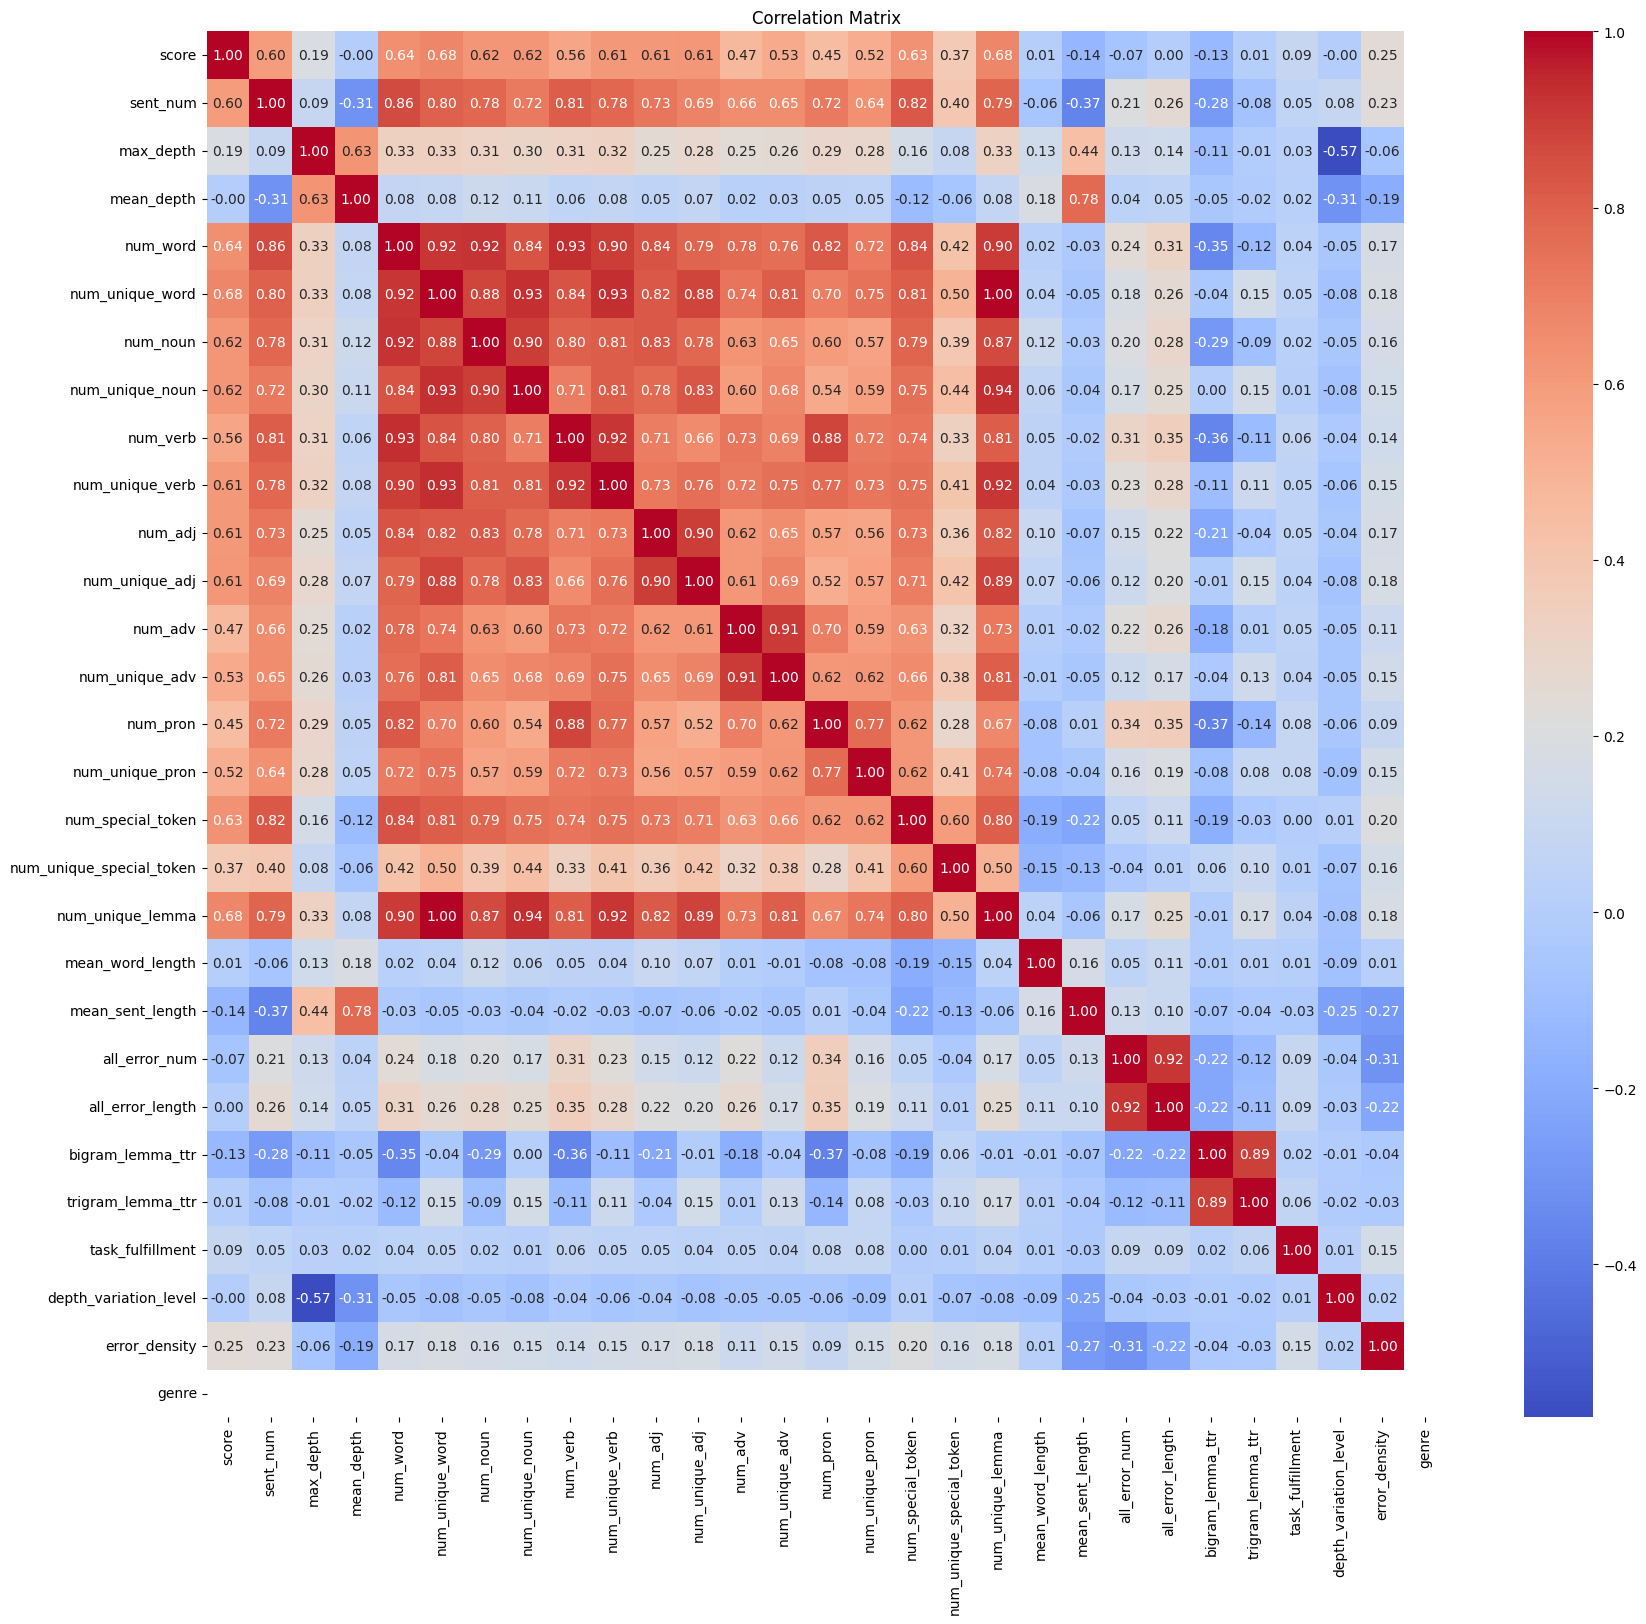

In [10]:
correlation_matrix = train_data.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

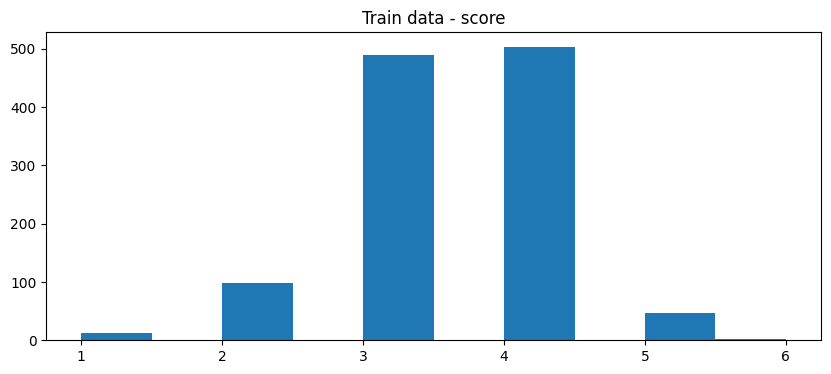

In [11]:
plt.figure(figsize=(10, 4))
plt.hist(train_data['score'])
plt.title("Train data - score")
plt.show()

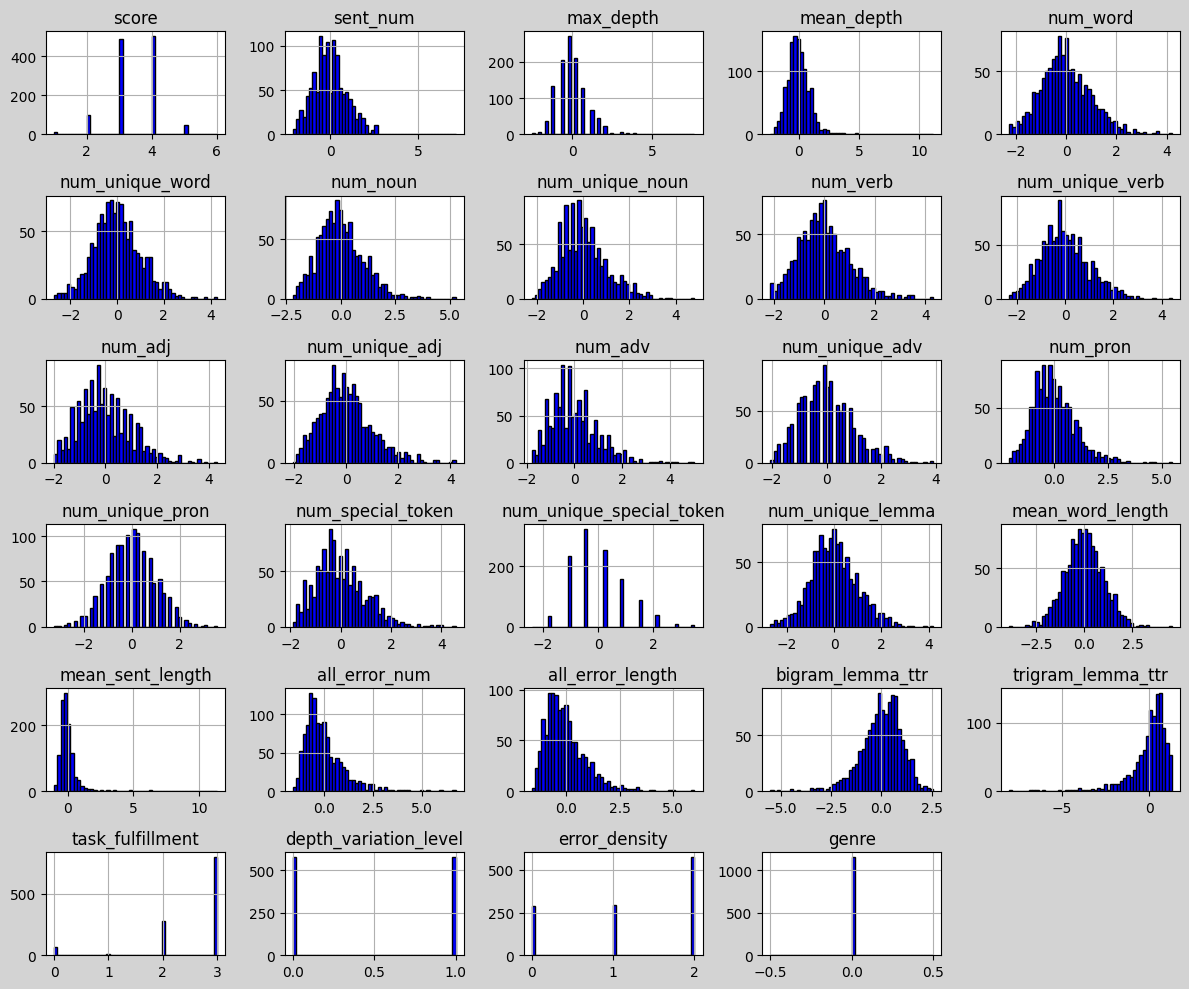

In [12]:
train_data.hist(figsize=(12, 10), color='blue', edgecolor='black',bins=50)
plt.gcf().set_facecolor('lightgrey')
plt.tight_layout()
plt.show()

### 特征选择
* LDA
* 随机森林
* 共线性情况

In [13]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = train_data.iloc[:,1:]
y = train_data['score']

# 初始化 LDA 模型
lda = LinearDiscriminantAnalysis()

# 使用 LDA 拟合数据
lda.fit(X, y)

# 获取特征的权重向量
feature_importances = lda.coef_

# 创建 DataFrame 来存储特征和其对应的权重
feature_lda_df = pd.DataFrame(data=feature_importances, columns=X.columns)

# 打印特征和其对应的权重
print("特征和其对应的权重：")
print(feature_lda_df)

selected_features_lda = feature_lda_df.abs().idxmax(axis=1)
print("选择的特征：")
print(selected_features_lda)

特征和其对应的权重：
   sent_num  max_depth  mean_depth  num_word  num_unique_word  num_noun  \
0  0.679472  -0.918021   -1.514137  7.498889        -2.946197 -0.310119   
1 -0.409229   0.056602   -0.408190  4.649241        -5.064916 -0.392993   
2 -0.066764   0.010203    0.063843 -0.717689         0.715429 -0.102053   
3  0.124510  -0.027913    0.092271 -0.965386         0.938077  0.471442   
4  0.087363   0.219612   -0.360901  6.102709        -5.021881 -3.307716   
5 -0.863308   2.071129   -1.044366 -0.274726       -24.444027  5.429502   

   num_unique_noun  num_verb  num_unique_verb   num_adj  ...  \
0         2.652185 -0.067113         2.195404 -0.934077  ...   
1         1.351543 -0.285160         1.198809 -0.791975  ...   
2         0.063522 -0.012730        -0.187002  0.007096  ...   
3        -0.524478  0.290965        -0.236990  0.278872  ...   
4         1.267346 -2.039285         1.026260 -1.006872  ...   
5         3.777899 -7.623812         8.694372 -3.402718  ...   

   mean_word_l

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# 初始化一个随机森林分类器
clf = RandomForestClassifier(
    n_estimators=40, 
    random_state=42)

# 使用随机森林进行特征选择
clf.fit(train_data.iloc[:,1:], train_data['score'])

# 获取特征重要性
feature_importances = clf.feature_importances_

feature_names = train_data.columns[1:]

# 打印每个特征的重要性
for i, (importance, feature_name) in enumerate(zip(feature_importances,feature_names)):
    print(f"{feature_name} - Importance: {importance}")
    
# 设定特征重要性阈值
threshold = 0.04
selected_features_randomf = []

# 打印大于阈值的特征
print("重要性大于阈值的特征：")
for i, (importance, feature_name) in enumerate(zip(feature_importances, feature_names)):
    if importance > threshold:
        selected_features_randomf.append(feature_name)
        print(f"{feature_name} - Importance: {importance}")

sent_num - Importance: 0.036361551065576654
max_depth - Importance: 0.016689232665368214
mean_depth - Importance: 0.02906924910918581
num_word - Importance: 0.07209196465085223
num_unique_word - Importance: 0.05012022502431322
num_noun - Importance: 0.06312178715033734
num_unique_noun - Importance: 0.03508303619210105
num_verb - Importance: 0.03344169535508701
num_unique_verb - Importance: 0.03623346113339875
num_adj - Importance: 0.05926046529415499
num_unique_adj - Importance: 0.04481276048158025
num_adv - Importance: 0.028050322352149572
num_unique_adv - Importance: 0.02171823867846829
num_pron - Importance: 0.03076352258795672
num_unique_pron - Importance: 0.023664381458666787
num_special_token - Importance: 0.0805786100073832
num_unique_special_token - Importance: 0.013318538339591927
num_unique_lemma - Importance: 0.08767724740482967
mean_word_length - Importance: 0.029996479500692716
mean_sent_length - Importance: 0.03215471377382659
all_error_num - Importance: 0.037440217543577

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns[:24]
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(24)]
print(vif_data)

selected_features_vif = vif_data[vif_data["VIF"] <= 30]["feature"]
print("VIF选择的变量：")
print(selected_features_vif)

                     feature         VIF
0                   sent_num    9.971675
1                  max_depth    2.739361
2                 mean_depth    4.724196
3                   num_word  117.946334
4            num_unique_word  245.797570
5                   num_noun   29.267670
6            num_unique_noun   24.627489
7                   num_verb   25.072875
8            num_unique_verb   24.911774
9                    num_adj    9.226032
10            num_unique_adj   11.950847
11                   num_adv    9.243089
12            num_unique_adv   10.261193
13                  num_pron   11.481330
14           num_unique_pron    4.456551
15         num_special_token    7.543484
16  num_unique_special_token    1.962728
17          num_unique_lemma  173.545676
18          mean_word_length    1.493566
19          mean_sent_length    2.997883
20             all_error_num    7.859187
21          all_error_length    7.307145
22          bigram_lemma_ttr   12.020372
23         trigr

In [ ]:
selected_features=[
    'num_unique_word',
    'num_unique_lemma',
    'mean_sent_length',    
    'num_special_token',
    'mean_depth',
    'all_error_length',
    'trigram_lemma_ttr'
]

In [25]:
selected_features = train_features.columns
selected_features = selected_features.drop('genre')
selected_features

Index(['sent_num', 'max_depth', 'mean_depth', 'num_word', 'num_unique_word',
       'num_noun', 'num_unique_noun', 'num_verb', 'num_unique_verb', 'num_adj',
       'num_unique_adj', 'num_adv', 'num_unique_adv', 'num_pron',
       'num_unique_pron', 'num_special_token', 'num_unique_special_token',
       'num_unique_lemma', 'mean_word_length', 'mean_sent_length',
       'all_error_num', 'all_error_length', 'bigram_lemma_ttr',
       'trigram_lemma_ttr', 'task_fulfillment', 'depth_variation_level',
       'error_density'],
      dtype='object')

In [26]:
train_data_use = train_data[selected_features]
validate_data_use = validate_data[selected_features]
test_data_use = test_features[selected_features]
train_data_use.head()

,sent_num,max_depth,mean_depth,num_word,num_unique_word,num_noun,num_unique_noun,num_verb,num_unique_verb,num_adj,...,num_unique_lemma,mean_word_length,mean_sent_length,all_error_num,all_error_length,bigram_lemma_ttr,trigram_lemma_ttr,task_fulfillment,depth_variation_level,error_density
1148,0.106674,1.631637,0.344182,0.540067,0.153556,1.260123,0.721809,0.776649,0.364087,-0.990679,...,0.022385,0.846543,0.012772,0.111869,0.468285,-0.888678,-0.420893,3,0,2
677,-0.532926,-0.681375,-0.138748,-0.465934,-0.775443,-0.734255,-0.812914,-0.230858,-0.185983,-0.741727,...,-0.819083,-0.780584,-0.043800,1.174908,1.207726,-0.082008,0.584319,3,1,0
221,-1.812125,-2.531784,-1.563980,-2.041045,-2.216339,-1.930882,-1.779221,-1.826077,-1.904952,-1.571567,...,-2.221531,-0.527151,-0.255258,-1.196487,-1.360857,1.638423,1.280493,0,1,2
113,0.213274,0.243830,-0.088048,0.189404,0.513780,0.707834,0.835492,-0.230858,0.157811,0.254081,...,0.583364,0.103649,-0.057321,-0.133448,-0.323046,0.755868,0.634711,3,0,2
845,0.426474,0.243830,-0.226853,0.724022,1.253187,0.646468,1.290225,0.734670,1.532986,0.337065,...,1.273800,-0.605281,-0.057897,-1.032942,-1.179240,1.254554,0.997533,2,0,1


### 定义模型

In [35]:
# 选择对共线性不敏感的模型

from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
svr_model = SVR()
decisiontree_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
gbtree_model = GradientBoostingRegressor(random_state=42)
nn_model = MLPRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42)

In [37]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

def cv_scores(model, x, y, cv=10):
    y_pred_cv = cross_val_predict(model, x, y, cv=cv)
    rmse_scores = np.sqrt(mean_squared_error(y, y_pred_cv))
    r2_scores = r2_score(y, y_pred_cv)
    print(f"RMSE Score: {rmse_scores}, R² Score: {r2_scores}")
    return rmse_scores, r2_scores

In [40]:
model_list = [
    ridge_model, 
    lasso_model,
    svr_model, 
    decisiontree_model, 
    rf_model,
    gbtree_model,
    nn_model,
    xgb_model
]

best_model = None
best_rmse = float('inf')

for model in model_list:
    model.fit(train_data_use, train_data['score'])
    print(str(model) + "训练集表现：")
    cv_scores(model, train_data_use, train_data['score'])
    pred = model.predict(validate_data_use)
    rmse = np.sqrt(mean_squared_error(validate_data['score'], pred))  # 计算验证集的RMSE
    r2 = r2_score(validate_data['score'], pred)  # 计算验证集的R²
    print(f"{str(model)}验证集表现： RMSE: {rmse}, R²: {r2}")
    
    if rmse < best_rmse:  # 如果当前模型的RMSE更低，则更新最佳模型和最佳RMSE
        best_rmse = rmse
        best_model = model

print("最佳模型：", best_model)
print("最佳模型验证集RMSE：", best_rmse)

Ridge(random_state=42)训练集表现：
RMSE Score: 0.5193536144766088, R² Score: 0.5263310064723392
Ridge(random_state=42)验证集表现： RMSE: 0.5120659793785948, R²: 0.5987810387421852
Lasso(random_state=42)训练集表现：
RMSE Score: 0.7547199885193705, R² Score: -0.00027714139241141744
Lasso(random_state=42)验证集表现： RMSE: 0.8090203266228166, R²: -0.001494271957496407
SVR()训练集表现：
RMSE Score: 0.5188917240813213, R² Score: 0.5271731528037511
SVR()验证集表现： RMSE: 0.5169882144382404, R²: 0.591030530199592
DecisionTreeRegressor(random_state=42)训练集表现：
RMSE Score: 0.7168604389202189, R² Score: 0.09756097560975607
DecisionTreeRegressor(random_state=42)验证集表现： RMSE: 0.7071067811865476, R²: 0.2349327577619127
RandomForestRegressor(random_state=42)训练集表现：
RMSE Score: 0.5047798440629561, R² Score: 0.5525416158536586
RandomForestRegressor(random_state=42)验证集表现： RMSE: 0.502446445460166, R²: 0.6137138303171177
GradientBoostingRegressor(random_state=42)训练集表现：
RMSE Score: 0.5059785445083304, R² Score: 0.55041393414148
GradientBoostin

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(random_state=42)训练集表现：


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

RMSE Score: 0.5739590533389026, R² Score: 0.4214905455244481
MLPRegressor(random_state=42)验证集表现： RMSE: 0.5676319969092697, R²: 0.5069813598933205
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)训练集表现：
RMSE Score: 0.5463912340997293, R² Score: 0.4757286973055166
XGBRegressor(base_score=None, booster=None

### 参数调优

In [42]:
from sklearn.model_selection import GridSearchCV

# 定义随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)

# 定义超参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 2, 4]  # 叶子节点最小样本数
}

# 定义 GridSearchCV 对象
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

# 在训练数据上进行网格搜索和交叉验证
grid_search_rf.fit(train_data_use, train_data['score'])

# 输出最佳参数和对应的得分（转换为RMSE）
best_params = grid_search_rf.best_params_
best_rmse = np.sqrt(np.abs(grid_search_rf.best_score_))
print("最佳参数：", best_params)
print("最佳得分（RMSE）：", best_rmse)

# 使用最佳参数的随机森林模型进行预测
best_rf_model = grid_search_rf.best_estimator_
pred = best_rf_model.predict(validate_data_use)

# 计算验证集的RMSE
rmse = np.sqrt(mean_squared_error(validate_data['score'], pred))
print("随机森林验证集RMSE：", rmse)

最佳参数： {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
最佳得分（RMSE）： 0.4981397782562757
随机森林验证集RMSE： 0.500969756301217


In [43]:
pred_full = best_rf_model.predict(test_data_use)

In [45]:
output_dict = {
    'essay_id': test['essay_id'],
    'score': pred_full
}
output_df = pd.DataFrame(output_dict)
output_df.to_csv("/kaggle/working/submission_svr.csv", index=False)